# Analyse de sentiment

In [1]:
# Import the data
import pandas as pd
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

#test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/testdata.manual.2009.06.14.csv", 
#                   header=None)  
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv",
                    header=None,encoding_errors='ignore') 


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re 
import time

import nltk
nltk.download('punkt')# Si les packages de NLTK ne sont pas déjà téléchargés
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Bibliothèque scikit learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing as pp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
from keras.optimizers import SGD, Adam

# Partie graphique
from wordcloud import WordCloud
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# Nombre d'éléments 
N=10000
data = pd.concat([train.head(N),train.tail(N)], axis=0)
# Renommage des colonnes et sélection des colonnes utiles
data.columns = ["target", "ids", "date", "flag", "user", "text"]
data = data[["target", "text"]]

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def clean_tweet(tweet):
    tweet = re.sub(r"http\S+", "", tweet)  # Suppression des liens
    tweet = re.sub(r"@[A-Za-z0-9]+", "", tweet)  # Suppression des mentions
    tweet = re.sub(r"[^a-zA-Z]", " ", tweet)  # Suppression des caractères spéciaux
    tweet = tweet.lower()  # Conversion en minuscules
    words = tweet.split()
    words = [stemmer.stem(word) for word in words ] #if word not in stop_words]  # Stemming et suppression des mots vides
    tweet = " ".join(words)
    return tweet
t0 = time.time()
data["text"] = data["text"].apply(clean_tweet)
print("Time to clean words :",time.time()-t0, "seconds")

Time to clean words : 2.571944236755371 seconds


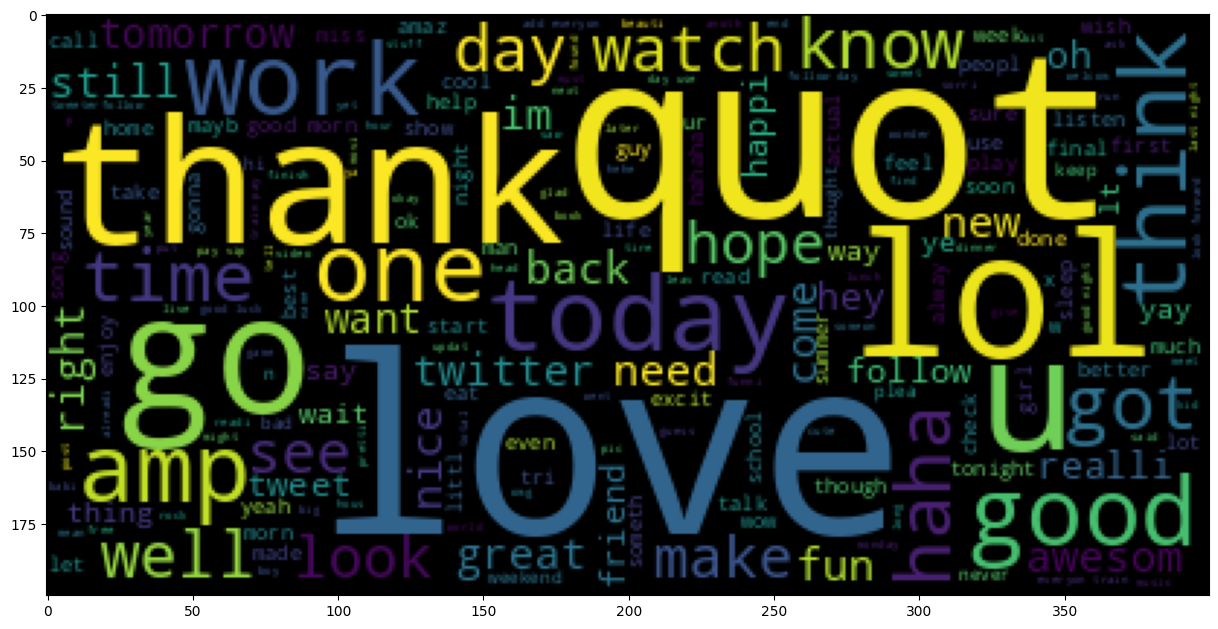

In [4]:
#String of positive tweets to analyze the words
positive_tweets = data[data['target'] == 4]['text'].tolist()
positive_tweets_string = " ".join(positive_tweets)
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(positive_tweets_string))
del positive_tweets, positive_tweets_string

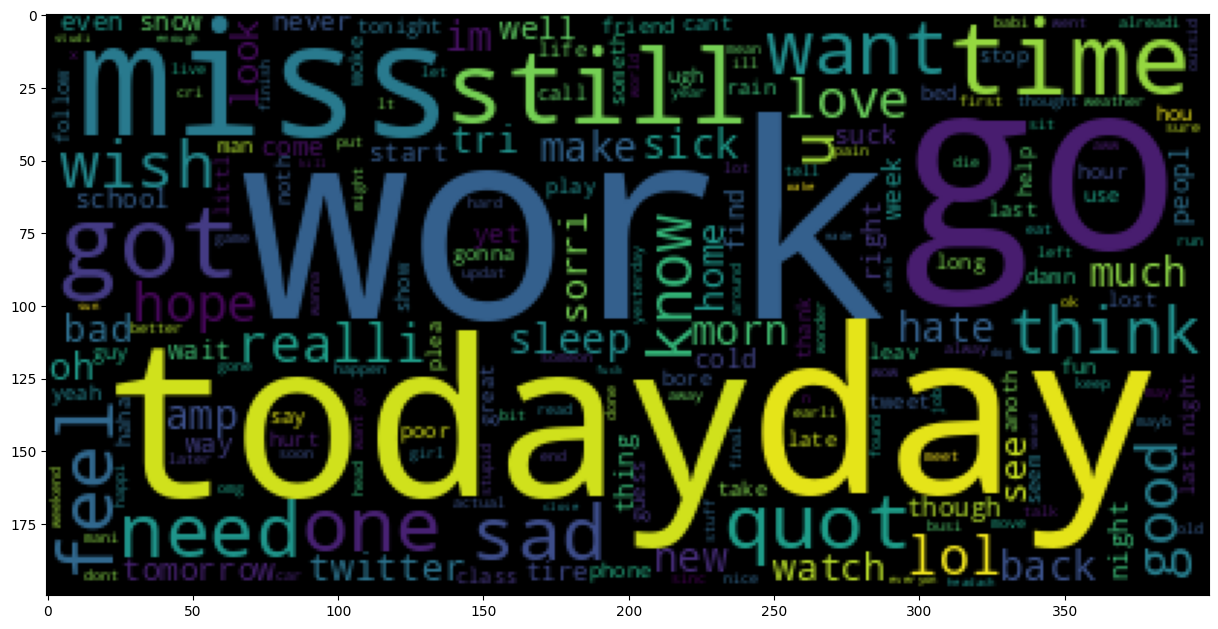

In [56]:
# creating the string of negative tweets to analyze the words
negative_tweets = data[data['target'] == 0]['text'].tolist()
negative_tweets_string = " ".join(negative_tweets)
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(negative_tweets_string))
del negative_tweets, negative_tweets_string

In [13]:
#Calculer TF-IDF
t0 = time.time()
tf_idf=TfidfVectorizer(ngram_range=(1,2), max_features=10000) #TfidfVectorizer(max_features=10000,min_df=5) # 
X=tf_idf.fit_transform(data['text']).toarray()
del tf_idf
print("Time to TF-IDF and vectorise data :",time.time()-t0, "seconds")
Y=np.array(data['target'])/4
#del data, train
#on sépare nos données pour se créer un fichier train et un fichier test
#x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.8,shuffle=True) 

Time to TF-IDF and vectorise data : 1.9119229316711426 seconds


In [14]:
#Réseau de neurones
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=X.shape[1]))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                200020    
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 200,241
Trainable params: 200,241
Non-trainable params: 0
_________________________________________________________________


In [15]:
t0 = time.time()
history = model.fit(X, Y, epochs=50, validation_split=0.2)
print("Time to fit model :",time.time()-t0, "seconds")

Epoch 1/50
500/500 [==============================] - 5s 9ms/step - loss: 0.5604 - accuracy: 0.7109 - val_loss: 0.6749 - val_accuracy: 0.6712
Epoch 2/50
500/500 [==============================] - 3s 6ms/step - loss: 0.3651 - accuracy: 0.8459 - val_loss: 0.7023 - val_accuracy: 0.6817
Epoch 3/50
500/500 [==============================] - 3s 6ms/step - loss: 0.2768 - accuracy: 0.8885 - val_loss: 0.7701 - val_accuracy: 0.6955
Epoch 4/50
500/500 [==============================] - 3s 6ms/step - loss: 0.2217 - accuracy: 0.9169 - val_loss: 0.9892 - val_accuracy: 0.6675
Epoch 5/50
500/500 [==============================] - 3s 7ms/step - loss: 0.1783 - accuracy: 0.9364 - val_loss: 1.1683 - val_accuracy: 0.6635
Epoch 6/50
500/500 [==============================] - 4s 7ms/step - loss: 0.1411 - accuracy: 0.9526 - val_loss: 1.3879 - val_accuracy: 0.6628
Epoch 7/50
500/500 [==============================] - 3s 6ms/step - loss: 0.1114 - accuracy: 0.9630 - val_loss: 1.7230 - val_accuracy: 0.6455
Epoch 

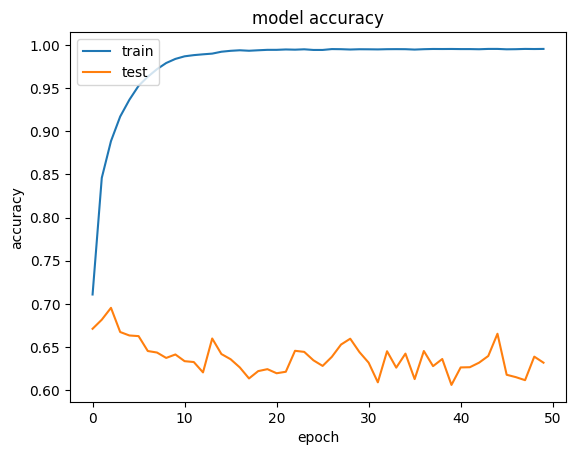

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
Prediction=model.predict(x_test).round().astype(int)

NameError: ignored

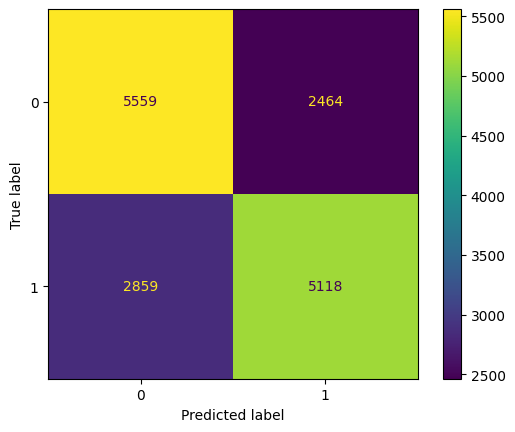

In [50]:
cm=confusion_matrix(y_test,Prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()